In [1]:
# =======================
# ADFGVX Cipher Evaluation (Both Modes + CDCI)
# =======================

In [2]:
import random, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
# from caas_jupyter_tools import display_dataframe_to_user

In [3]:

random.seed(42); np.random.seed(42)
ALPHABET36 = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
ADFGVX = "ADFGVX"

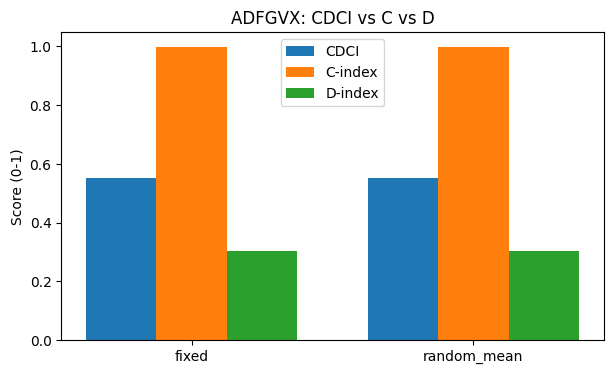

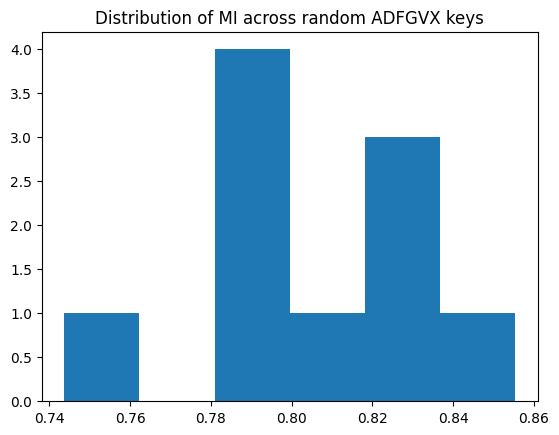

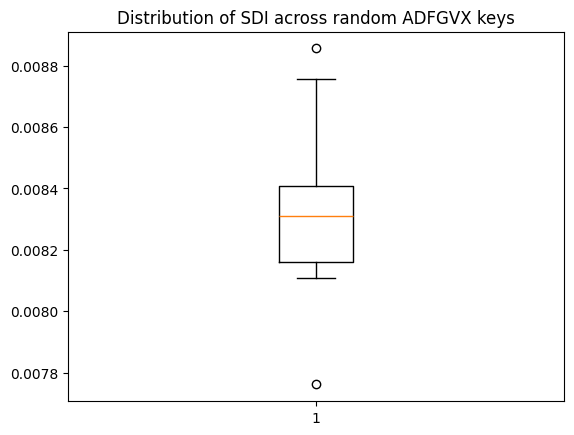

Saved: adfgvx_fixed.csv, adfgvx_random.csv, adfgvx_summary.csv


In [4]:
# ---------------- Polybius + Transposition ----------------
def build_polybius_square(key):
    seen = []
    for ch in key.upper():
        if ch not in seen and ch in ALPHABET36:
            seen.append(ch)
    for ch in ALPHABET36:
        if ch not in seen:
            seen.append(ch)
    coords = {}
    for idx, ch in enumerate(seen):
        coords[ch] = (ADFGVX[idx//6], ADFGVX[idx%6])
    return coords

def adfgvx_encrypt(plaintext, poly_key, trans_key):
    coords = build_polybius_square(poly_key)
    pairs = []
    for ch in plaintext.upper():
        if ch in coords:
            r,c = coords[ch]
            pairs.append(r+c)
    sub_text = "".join(pairs)
    ncols = len(trans_key)
    order = sorted(list(enumerate(trans_key)), key=lambda x: x[1])
    grid = [sub_text[i:i+ncols] for i in range(0,len(sub_text),ncols)]
    if len(grid[-1]) < ncols:
        grid[-1] += random.choice(ADFGVX)*(ncols-len(grid[-1]))
    ct=""
    for idx,_ in order:
        ct += "".join(row[idx] for row in grid)
    return ct

# ---------------- Metrics ----------------
def fraction_changed(a,b):
    L=min(len(a),len(b))
    return sum(x!=y for x,y in zip(a[:L],b[:L]))/L if L else 0

def symbol_diffusion_index(cipher_fun, plaintext, keys, trials=10):
    base_ct = cipher_fun(plaintext, *keys)
    results=[]
    L=len(plaintext)
    for _ in range(trials):
        i=random.randrange(L)
        newch=random.choice([c for c in ALPHABET36 if c!=plaintext[i]])
        P2=plaintext[:i]+newch+plaintext[i+1:]
        ct2=cipher_fun(P2, *keys)
        results.append(fraction_changed(base_ct,ct2))
    return np.mean(results), np.std(results)

def compute_ksi(cipher_fun, plaintext, keypair, pertpair):
    C1=cipher_fun(plaintext,*keypair)
    C2=cipher_fun(plaintext,*pertpair)
    return fraction_changed(C1,C2)

def mutual_information(pairs):
    N=len(pairs)
    if N==0: return 0.0
    joint=Counter(pairs)
    X=Counter(x for x,_ in pairs); Y=Counter(y for _,y in pairs)
    mi=0.0
    for (x,y),n in joint.items():
        pxy=n/N; px=X[x]/N; py=Y[y]/N
        mi+=pxy*math.log2(pxy/(px*py))
    return mi

def compute_chi_entropy(text, alphabet):
    N=len(text)
    if N==0: return 0.0,0.0
    counts=Counter(text); expected=N/len(alphabet)
    chi2=sum((counts[a]-expected)**2/expected for a in alphabet)
    H=-sum((counts[a]/N)*math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2,H

def bootstrap_mi(pairs, n_boot=200, alpha=0.05):
    N=len(pairs)
    if N==0: return 0.0,(0,0)
    est=[]
    for _ in range(n_boot):
        sample=[pairs[random.randrange(N)] for _ in range(N)]
        est.append(mutual_information(sample))
    est.sort()
    low=est[int((alpha/2)*n_boot)]; high=est[int((1-alpha/2)*n_boot)]
    return np.mean(est),(low,high)

# CDCI
def confusion_index(cipher_fun, plaintext, keyspace, samples=100):
    pairs=[]
    for _ in range(samples):
        pk,tk=random.choice(keyspace)
        C=cipher_fun(plaintext,pk,tk)
        for sym in C:
            pairs.append((pk[0],sym)) # coarse key symbol
    mi=mutual_information(pairs)
    Hk=math.log2(len(keyspace)) if len(keyspace)>1 else 1.0
    return max(0,1-mi/Hk)

def diffusion_index(cipher_fun, plaintext, keypair, alpha=0.7):
    sdi_mean,sdi_std=symbol_diffusion_index(cipher_fun, plaintext, keypair)
    C=cipher_fun(plaintext,*keypair)
    _,H=compute_chi_entropy(C,ADFGVX)
    normH=H/math.log2(len(ADFGVX))
    D=alpha*sdi_mean+(1-alpha)*normH
    return D,sdi_mean,sdi_std,normH

def cdci_score(cipher_fun, plaintext, keypair, keyspace, alpha=0.7):
    Cidx=confusion_index(cipher_fun, plaintext, keyspace)
    D,sdi_mean,sdi_std,normH=diffusion_index(cipher_fun, plaintext, keypair,alpha)
    return math.sqrt(Cidx*D),Cidx,D,sdi_mean,sdi_std,normH

# ---------------- Experiment ----------------
num_texts=5; length=200
plaintexts=["".join(random.choice(ALPHABET36) for _ in range(length)) for _ in range(num_texts)]
plaintexts[0]=("THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG0123456789"*5)[:length]

fixed_poly="PH0QG64MEA1YL2NOFDZXKR3CVS5W7BJ9UTI8"
fixed_trans="GERMAN"
random_keys=[("".join(random.sample(ALPHABET36,36)),"".join(random.sample("GERMANXYZ",6))) for _ in range(10)]
keyspace=[("".join(random.sample(ALPHABET36,36)),"".join(random.sample("GERMANXYZ",6))) for _ in range(50)]

# Mode A Fixed
fixed_results={}
sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; Hs=[]; mi_boot=[]
for pt in plaintexts:
    sdi_mean,sdi_std=symbol_diffusion_index(adfgvx_encrypt,pt,(fixed_poly,fixed_trans))
    sdi_vals.append(sdi_mean)
    pert=(fixed_poly[::-1],fixed_trans) # crude perturbation
    ksi_vals.append(compute_ksi(adfgvx_encrypt,pt,(fixed_poly,fixed_trans),pert))
    C=adfgvx_encrypt(pt,fixed_poly,fixed_trans)
    mi_vals.append(mutual_information(list(zip(pt,C[:len(pt)]))))
    chi,H=compute_chi_entropy(C,ADFGVX); chi_vals.append(chi); Hs.append(H)
    mboot,_=bootstrap_mi(list(zip(pt,C[:len(pt)])),n_boot=100); mi_boot.append(mboot)

fixed_cdci,Cidx,Didx,sdi_mean,sdi_std,normH=cdci_score(adfgvx_encrypt,plaintexts[0],(fixed_poly,fixed_trans),keyspace)
fixed_results.update({
    "SDI_mean":np.mean(sdi_vals),
    "KSI_mean":np.mean(ksi_vals),
    "MI_mean":np.mean(mi_vals),
    "Entropy_mean":np.mean(Hs),
    "Chi2_mean":np.mean(chi_vals),
    "MI_boot_mean":np.mean(mi_boot),
    "CDCI":fixed_cdci,"C_index":Cidx,"D_index":Didx
})
fixed_df=pd.DataFrame([fixed_results])

# Mode B Random
rand_res=[]
for pk,tk in random_keys:
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; Hs=[]
    for pt in plaintexts:
        sdi_mean,_=symbol_diffusion_index(adfgvx_encrypt,pt,(pk,tk))
        sdi_vals.append(sdi_mean)
        ksi_vals.append(compute_ksi(adfgvx_encrypt,pt,(pk,tk),(pk[::-1],tk)))
        C=adfgvx_encrypt(pt,pk,tk)
        mi_vals.append(mutual_information(list(zip(pt,C[:len(pt)]))))
        chi,H=compute_chi_entropy(C,ADFGVX); chi_vals.append(chi); Hs.append(H)
    CDCI,Cidx,Didx,sdi_mean,sdi_std,normH=cdci_score(adfgvx_encrypt,plaintexts[0],(pk,tk),keyspace)
    rand_res.append({
        "SDI_mean":np.mean(sdi_vals),"KSI_mean":np.mean(ksi_vals),
        "MI_mean":np.mean(mi_vals),"Entropy_mean":np.mean(Hs),"Chi2_mean":np.mean(chi_vals),
        "CDCI":CDCI,"C_index":Cidx,"D_index":Didx
    })
random_df=pd.DataFrame(rand_res)

summary=pd.DataFrame({
    "mode":["fixed","random_mean"],
    "SDI_mean":[fixed_results["SDI_mean"],random_df["SDI_mean"].mean()],
    "KSI_mean":[fixed_results["KSI_mean"],random_df["KSI_mean"].mean()],
    "MI_mean":[fixed_results["MI_mean"],random_df["MI_mean"].mean()],
    "Entropy_mean":[fixed_results["Entropy_mean"],random_df["Entropy_mean"].mean()],
    "CDCI":[fixed_results["CDCI"],random_df["CDCI"].mean()],
    "C_index":[fixed_results["C_index"],random_df["C_index"].mean()],
    "D_index":[fixed_results["D_index"],random_df["D_index"].mean()]
})

# Outputs
# display_dataframe_to_user("ADFGVX Fixed Results",fixed_df)
# display_dataframe_to_user("ADFGVX Random Results",random_df)
# display_dataframe_to_user("ADFGVX Summary",summary)

# Plots
x=np.arange(len(summary)); width=0.25
fig,ax=plt.subplots(figsize=(7,4))
ax.bar(x-width,summary["CDCI"],width,label="CDCI")
ax.bar(x,summary["C_index"],width,label="C-index")
ax.bar(x+width,summary["D_index"],width,label="D-index")
ax.set_xticks(x); ax.set_xticklabels(summary["mode"])
ax.set_ylabel("Score (0-1)"); ax.set_title("ADFGVX: CDCI vs C vs D"); ax.legend(); plt.show()

plt.hist(random_df["MI_mean"],bins=6); plt.title("Distribution of MI across random ADFGVX keys"); plt.show()
plt.boxplot(random_df["SDI_mean"]); plt.title("Distribution of SDI across random ADFGVX keys"); plt.show()

fixed_df.to_csv("./data/adfgvx_fixed.csv",index=False)
random_df.to_csv("./data/adfgvx_random.csv",index=False)
summary.to_csv("./data/adfgvx_summary.csv",index=False)
print("Saved: adfgvx_fixed.csv, adfgvx_random.csv, adfgvx_summary.csv")

In [5]:
fixed_df

,SDI_mean,KSI_mean,MI_mean,Entropy_mean,Chi2_mean,MI_boot_mean,CDCI,C_index,D_index
0,0.008159,1.0,0.826456,2.575899,5.044776,1.186091,0.550348,0.998396,0.30337


In [6]:
random_df

,SDI_mean,KSI_mean,MI_mean,Entropy_mean,Chi2_mean,CDCI,C_index,D_index
0,0.008408,1.000000,0.818734,2.575709,5.194030,0.550078,0.998621,0.303003
1,0.008308,1.000000,0.834872,2.576149,4.871642,0.551110,0.998658,0.304130
2,0.008109,0.996020,0.855406,2.575632,5.217910,0.552435,0.998519,0.305637
3,0.008856,0.999005,0.794471,2.578449,3.605970,0.551548,0.998586,0.304636
4,0.008308,0.997015,0.828848,2.579993,2.782090,0.552042,0.998306,0.305267
5,0.008756,1.000000,0.797421,2.576132,4.853731,0.551578,0.998585,0.304669
6,0.008408,0.999005,0.813671,2.576523,4.656716,0.550728,0.998638,0.303715
7,0.008109,1.000000,0.798615,2.576525,4.626866,0.551597,0.998492,0.304719
8,0.007761,1.000000,0.786636,2.575501,5.307463,0.550039,0.998341,0.303045
9,0.008308,1.000000,0.743666,2.572533,6.847761,0.550906,0.998418,0.303978


In [7]:
summary

,mode,SDI_mean,KSI_mean,MI_mean,Entropy_mean,CDCI,C_index,D_index
0,fixed,0.008159,1.000000,0.826456,2.575899,0.550348,0.998396,0.30337
1,random_mean,0.008333,0.999104,0.807234,2.576315,0.551206,0.998516,0.30428
